In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv("bank-marketing.csv")

In [3]:
df.head()

,age,job,salary,marital,education,targeted,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,58,management,100000,married,tertiary,yes,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,60000,single,secondary,yes,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,120000,married,secondary,yes,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,20000,married,unknown,no,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,0,single,unknown,no,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Read in the file and get basic information about the data, including numerical summaries.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   salary     45211 non-null  int64 
 3   marital    45211 non-null  object
 4   education  45211 non-null  object
 5   targeted   45211 non-null  object
 6   default    45211 non-null  object
 7   balance    45211 non-null  int64 
 8   housing    45211 non-null  object
 9   loan       45211 non-null  object
 10  contact    45211 non-null  object
 11  day        45211 non-null  int64 
 12  month      45211 non-null  object
 13  duration   45211 non-null  int64 
 14  campaign   45211 non-null  int64 
 15  pdays      45211 non-null  int64 
 16  previous   45211 non-null  int64 
 17  poutcome   45211 non-null  object
 18  response   45211 non-null  object
dtypes: int64(8), object(11)
memory usage: 6.6+ MB


### Describe the pdays column, make note of the mean, median and minimum values. Anything fishy in the values?

In [6]:
df.pdays.describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

#### >>> It seems pdays column contains mostly -ve values. 
#### >>> Pdays means number of days that passed by after the client was last contacted from a previous campaign.
#### >>> No of days can't be negative.

### Describe the pdays column again, this time limiting yourself to the relevant values of pdays. How different are the mean and the median values? 

In [7]:
df1=df.copy()

In [10]:
npdays=df1['pdays']
df1['npdays'] =npdays
# df1['npdays'] = df1[df1['pdays'] > -1]
print("Mean ", np.around(df1['npdays'].mean(),2))
print("Median ", df1['npdays'].median())

Mean  40.2
Median  -1.0


### Plot a horizontal bar graph with the median values of balance for each education level value. Which group has the highest median?

<AxesSubplot:xlabel='balance', ylabel='education'>

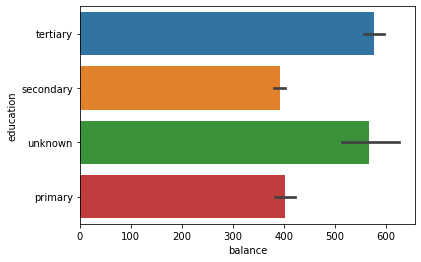

In [8]:
sn.barplot(x="balance", y="education", estimator=np.median, data=df)

#### >>> Tertiary Education has highest median.

### Make a box plot for pdays. Do you see any outliers?

<AxesSubplot:xlabel='npdays'>

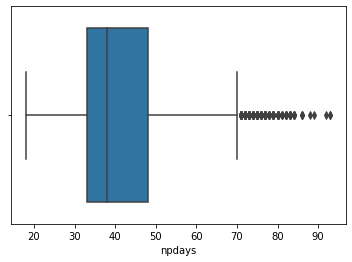

In [9]:
sn.boxplot(x=df1["npdays"])

#### >>> Yes, outliers are present.

## The final goal is to make a predictive model to predict if the customer will respond positively to the campaign or not. The target variable is “response”.

### First, perform bi-variate analysis to identify the features that are directly associated with the target variable. 

## Bi-Variate Analysis

### Converting the response variable to a convenient form

In [10]:
df1.replace({'response': {'yes':1, 'no':0}}, inplace = True)

### Make suitable plots for associations with numerical features and categorical features

In [11]:
num_feature=[]
cat_feature=[]
for i in df.columns:
    if df[i].dtypes=='O':
        cat_feature.append(i)
    else:
        num_feature.append(i)

In [12]:
print("Numerical Feature=",num_feature)
print()
print("Categorical Feature=",cat_feature)

Numerical Feature= ['age', 'salary', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical Feature= ['job', 'marital', 'education', 'targeted', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'response']


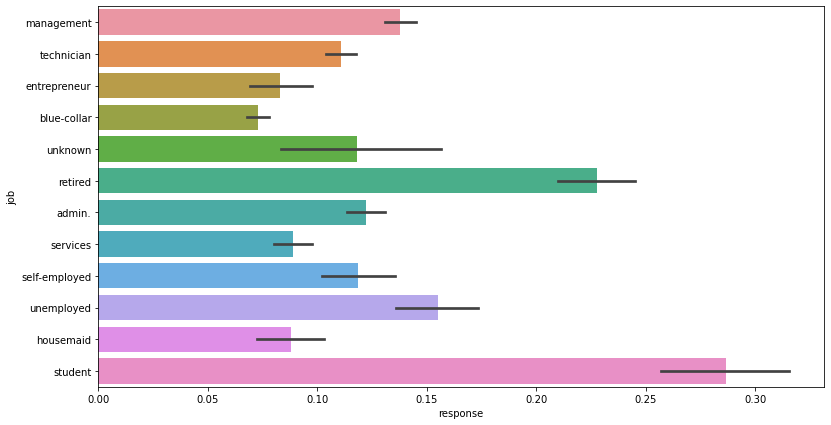

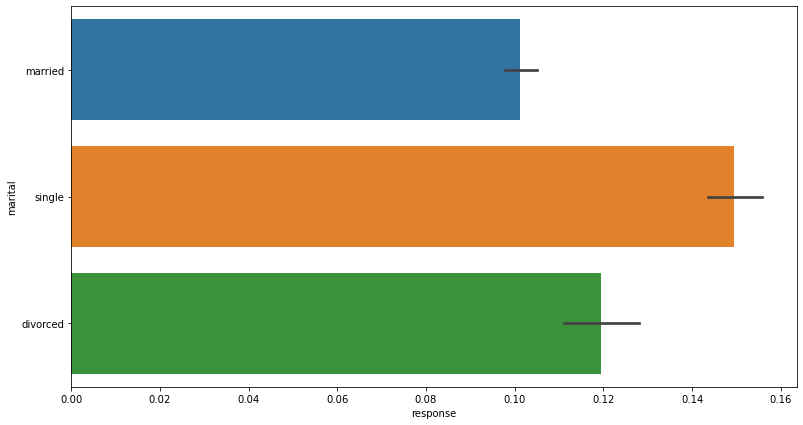

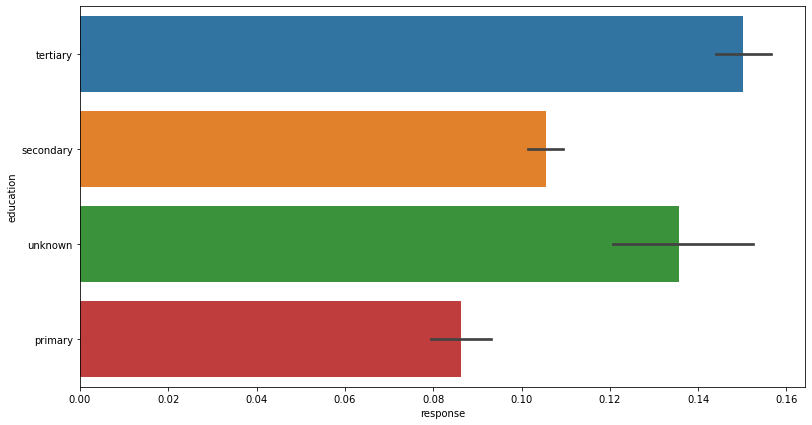

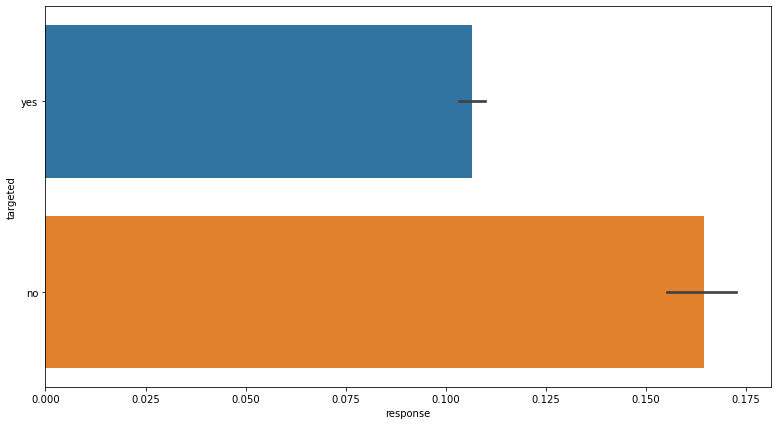

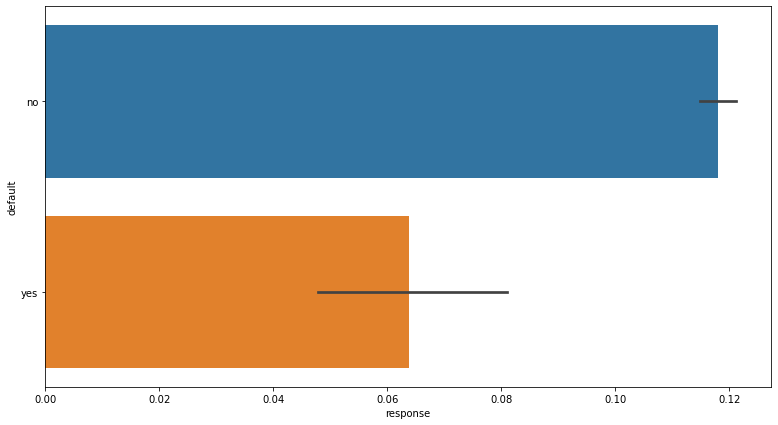

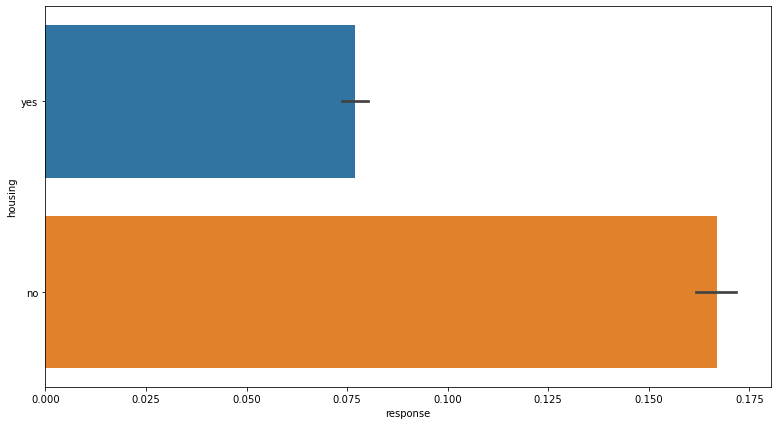

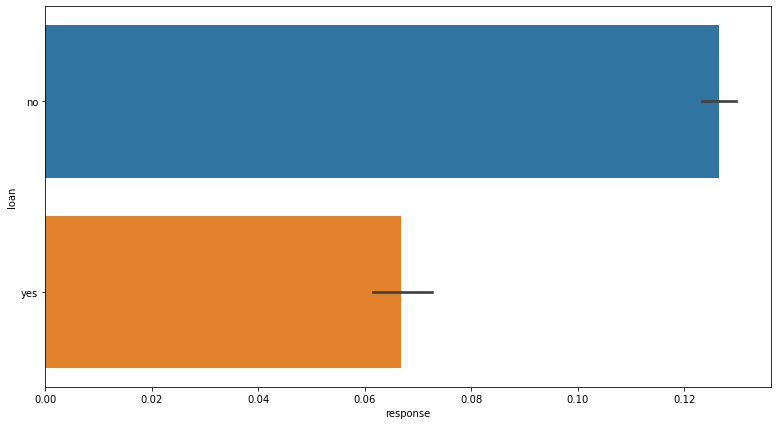

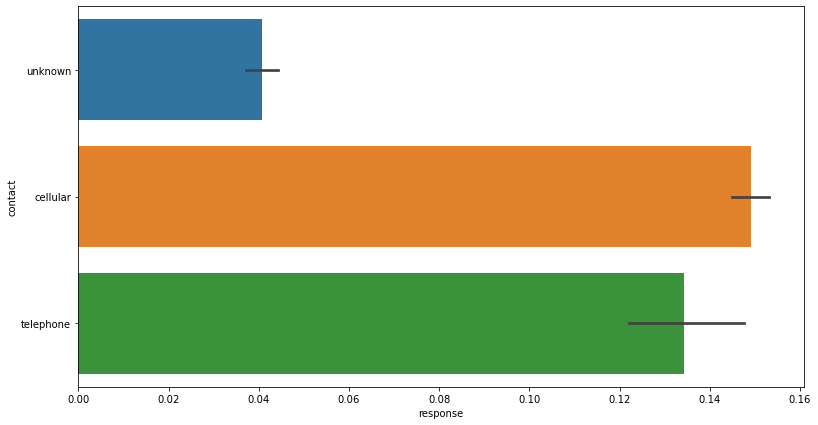

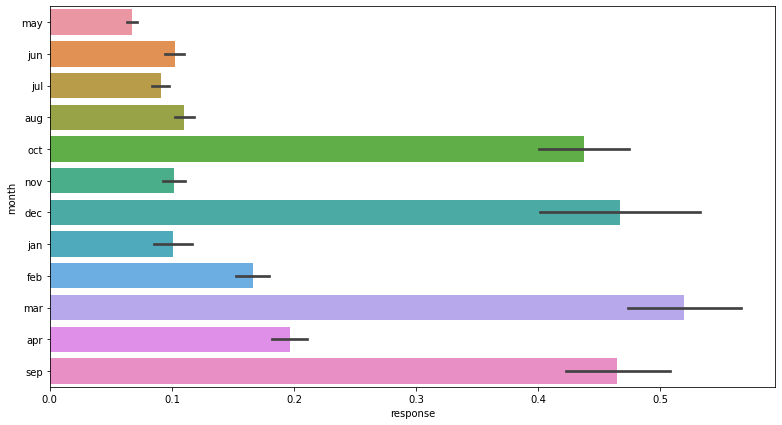

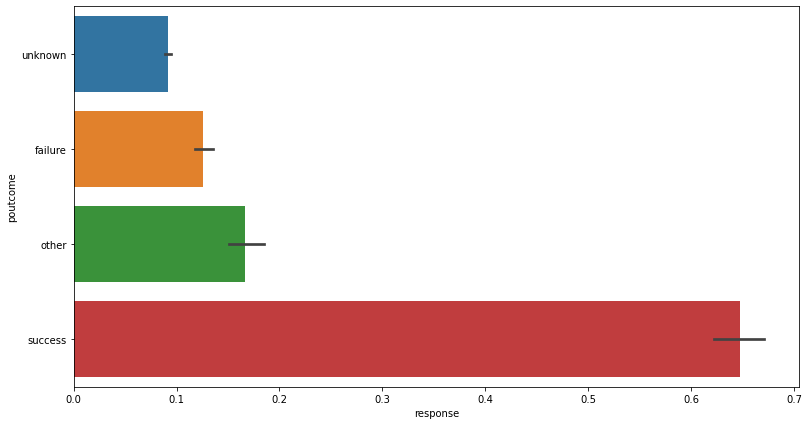

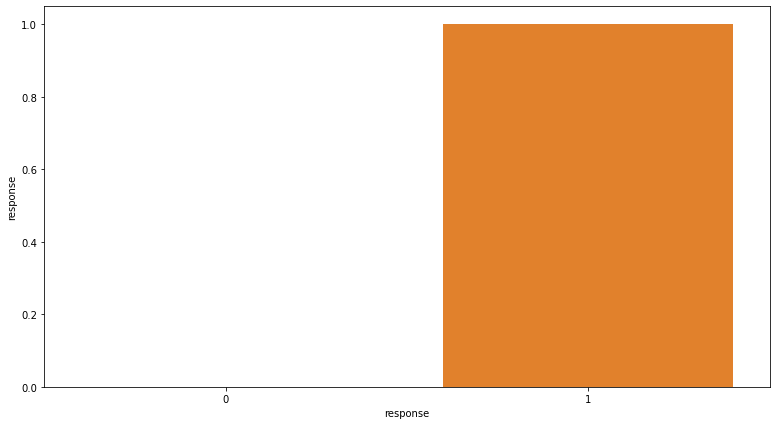

In [13]:
for i in cat_feature:
    plt.figure(figsize=(13,7))
    sn.barplot(df1['response'], df1[i])
    plt.show();

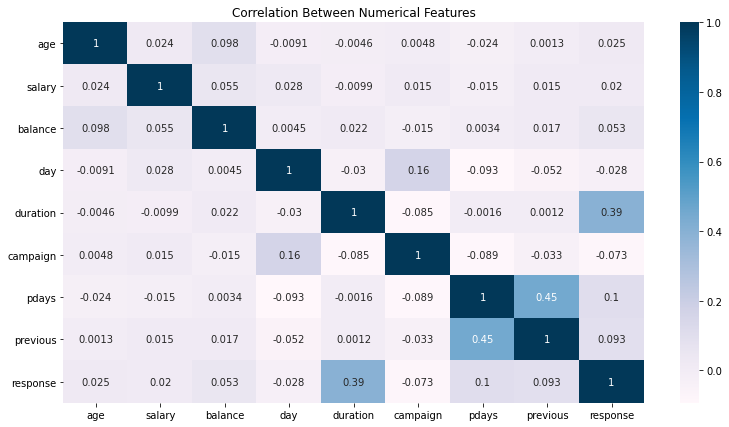

In [14]:
plt.figure(figsize=(13,7))
sn.heatmap(df1.corr(),annot=True,cmap='PuBu')
plt.title("Correlation Between Numerical Features");

#### >>> We can see there is somewhat good positive correlation between response & duration means duration affect on target.

### Age-Wise Response

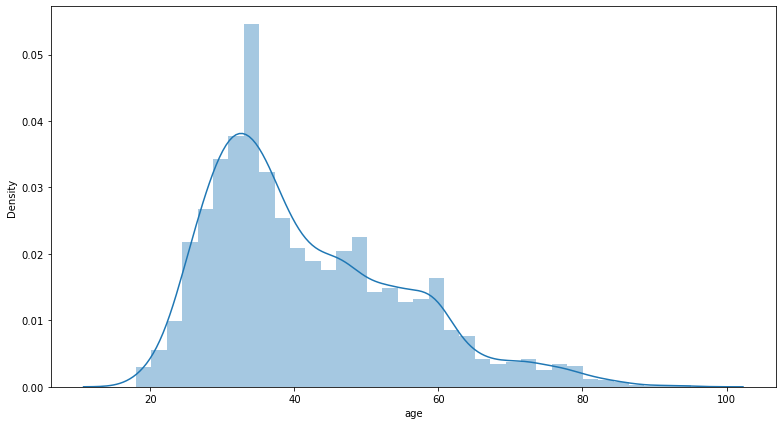

In [15]:
plt.figure(figsize=(13,7))
sn.distplot(df1[df1['response']==1].age);

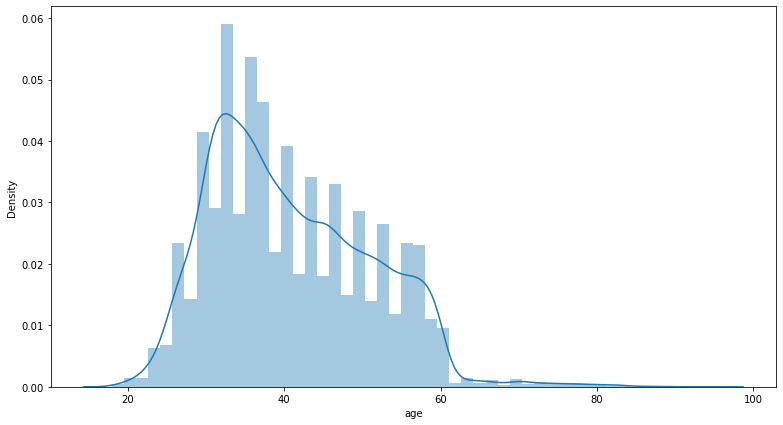

In [16]:
plt.figure(figsize=(13,7))
sn.distplot(df1[df1['response']==0].age);

### Are the features about the previous campaign data useful?

#### >>> Since, there is no such good correlation between the features. So the features about previous campaign data are somewhat useful.

### Are pdays and poutcome associated with the target? 

#### >>> Poutcome is the past data output so I don't think it will affect the target. Weak correlation is present between pdays and the target variable.

### If yes, and if you plan to use them – how do you handle the pdays column with a value of -1 where the previous campaign data is missing? Explain your approach and your decision

#### >>> Since, days can't be negative therefore dropping the rows where pdays is -1.

In [17]:
df1.drop(df[df['pdays']<0].index,inplace=True)

### Label Encoding of Categorical Variables

In [18]:
df2 = df1[cat_feature].apply(LabelEncoder().fit_transform)

In [19]:
df2.head()

,job,marital,education,targeted,default,housing,loan,contact,month,poutcome,response
24060,0,1,2,1,0,0,0,1,10,0,0
24062,0,2,1,1,0,1,1,1,10,1,1
24064,7,1,1,1,0,1,0,1,10,0,1
24072,4,1,2,1,0,1,0,1,10,1,0
24077,4,1,2,1,0,1,0,1,10,0,1


In [20]:
df3 = df2.join(df[num_feature])
df3.head()

,job,marital,education,targeted,default,housing,loan,contact,month,poutcome,response,age,salary,balance,day,duration,campaign,pdays,previous
24060,0,1,2,1,0,0,0,1,10,0,0,33,50000,882,21,39,1,151,3
24062,0,2,1,1,0,1,1,1,10,1,1,42,50000,-247,21,519,1,166,1
24064,7,1,1,1,0,1,0,1,10,0,1,33,70000,3444,21,144,1,91,4
24072,4,1,2,1,0,1,0,1,10,1,0,36,100000,2415,22,73,1,86,4
24077,4,1,2,1,0,1,0,1,10,0,1,36,100000,0,23,140,1,143,3


In [21]:
df3.shape

(8257, 19)

### Train test split

In [22]:
x = df3.drop('response', axis=1)

In [23]:
y = df3[['response']]

In [24]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=1)

### Predictive model 1: Logistic regression

In [25]:
LR=LogisticRegression()

In [26]:
LR.fit(x_train, y_train)

LogisticRegression()

In [27]:
y_pred=LR.predict(x_test)

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1294
           1       0.56      0.20      0.29       358

    accuracy                           0.79      1652
   macro avg       0.69      0.58      0.58      1652
weighted avg       0.76      0.79      0.75      1652



In [29]:
confusion_matrix(y_pred,y_test)

array([[1240,  288],
       [  54,   70]], dtype=int64)

### Use RFE to select top n features in an automated fashion (choose n as you see fit)

In [30]:
from sklearn.feature_selection import RFE
rfe=RFE(LR, 5)
rfe.fit(x_train,y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [31]:
rfe.support_

array([False, False, False,  True, False,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False])

In [32]:
x_train.columns[rfe.support_]

Index(['targeted', 'housing', 'loan', 'contact', 'poutcome'], dtype='object')

In [33]:
col=x_train.columns[rfe.support_]

In [34]:
LR.fit(x_train[col],y_train)

LogisticRegression()

In [35]:
y_Pred2 = LR.predict(x_test[col])

In [36]:
print(classification_report(y_Pred2,y_test))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1461
           1       0.39      0.73      0.51       191

    accuracy                           0.84      1652
   macro avg       0.68      0.79      0.71      1652
weighted avg       0.89      0.84      0.86      1652



In [37]:
confusion_matrix(y_Pred2,y_test)

array([[1243,  218],
       [  51,  140]], dtype=int64)

### Using p values and VIF, get rid of the redundant features

In [38]:
import statsmodels.api as sm

In [39]:
x_train.head()

,job,marital,education,targeted,default,housing,loan,contact,month,poutcome,age,salary,balance,day,duration,campaign,pdays,previous
44701,5,0,0,1,0,0,0,1,11,1,84,55000,1680,6,113,5,97,3
43668,6,1,2,1,0,0,0,0,8,0,43,60000,10072,12,98,1,77,5
35514,1,1,0,1,0,1,0,0,8,0,53,20000,2144,7,217,2,342,1
24253,0,1,1,1,0,1,0,0,9,0,39,50000,401,17,396,1,129,2
35448,4,2,2,0,0,1,0,0,8,0,31,100000,0,7,45,1,22,2


In [40]:
x_train_sm=sm.add_constant(x_train[col])

In [41]:
x_train_sm.head()

,const,targeted,housing,loan,contact,poutcome
44701,1.0,1,0,0,1,1
43668,1.0,1,0,0,0,0
35514,1.0,1,1,0,0,0
24253,1.0,1,1,0,0,0
35448,1.0,0,1,0,0,0


In [42]:
LR1 = sm.OLS(y_train, x_train_sm).fit()

In [43]:
LR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     375.7
Date:                Thu, 09 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:16:50   Log-Likelihood:                -2869.9
No. Observations:                6605   AIC:                             5752.
Df Residuals:                    6599   BIC:                             5793.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2805      0.013     21.529      0.000       0.255       0.306
targeted      -0.0427      0.012     -3.680      0.000      -0.065      -0.020
housing       -0.1791      0.010    -17.966      0.000      -0.199      -0.160
loan          -0.0665      0.014     -4.885      0.000      -0.093      -0.040
contact       -0.0560      0.014     -3.866      0.000      -0.084      -0.028
poutcome       0.1891      0.006     30.876      0.000       0.177       0.201
==============================================================================
Omnibus:                      735.062   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1002.678
Skew:                           0.944   Prob(JB):                    1.87e-218
Kurtosis:                       3.274   Cond. No.                         5.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
vif=pd.DataFrame()
vif['Features']=x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,age,11.915654
3,targeted,6.539455
2,education,6.533275
11,salary,5.401943
16,pdays,5.241166
1,marital,4.318085
13,day,4.098138
8,month,3.622587
5,housing,3.111419
0,job,2.868584


In [46]:
F_col = ['education', 'job', 'poutcome', 'marital', 'month','targeted', 'housing', 'salary','day','duration','age']

In [47]:
log = sm.GLM(y_train,(sm.add_constant(x_train[F_col])), family = sm.families.Binomial())

In [48]:
log.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                 6605
Model:                            GLM   Df Residuals:                     6593
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2580.9
Date:                Thu, 09 Sep 2021   Deviance:                       5161.7
Time:                        16:16:50   Pearson chi2:                 6.85e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0476      0.296    -10.285      0.000      -3.628      -2.467
education      0.1900      0.068      2.799      0.005       0.057       0.323
job            0.0141      0.011      1.262      0.207      -0.008       0.036
poutcome       1.0559      0.042     24.927      0.000       0.973       1.139
marital        0.1397      0.067      2.082      0.037       0.008       0.271
month          0.0084      0.010      0.834      0.404      -0.011       0.028
targeted      -0.0576      0.113     -0.509      0.611      -0.279       0.164
housing       -1.1663      0.075    -15.588      0.000      -1.313      -1.020
salary      4.435e-07   1.21e-06      0.366      0.714   -1.93e-06    2.82e-06
day            0.0024      0.004      0.557      0.577      -0.006       0.011
duration       0.0035      0.000     22.417      0.000       0.003       0.004
age            0.0021      0.003      0.645      0.519      -0.004       0.009
==============================================================================
"""

In [49]:
LR.fit(x_train[F_col],y_train)

LogisticRegression()

In [50]:
LR.classes_

array([0, 1], dtype=int64)

In [51]:
LR.coef_

array([[ 6.14177233e-03,  1.05594585e-02,  1.66330689e-01,
        -3.96338908e-02, -1.38465492e-01, -4.37385417e-02,
        -1.13206480e-01, -2.88532524e-06, -6.75126672e-03,
         2.74869298e-03, -2.11296032e-02]])

In [52]:
predf = LR.predict(x_test[F_col])

In [53]:
def LR_matric():    
    print('Report:\n',classification_report(y_test,predf ))
    print('confusion Matrix:\n',confusion_matrix(predf,y_test))
    print()
    print('kfold cross validation:\n',cross_val_score(LR, x, y, cv=5))

In [54]:
LR_matric()

Report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.88      1294
           1       0.55      0.20      0.30       358

    accuracy                           0.79      1652
   macro avg       0.68      0.58      0.59      1652
weighted avg       0.76      0.79      0.75      1652

confusion Matrix:
 [[1234  285]
 [  60   73]]

kfold cross validation:
 [0.79539952 0.70762712 0.77892187 0.7752877  0.75529982]


### Predictive model 2: Random Forest

In [55]:
RFC = RandomForestClassifier(max_depth=5,random_state=0,max_leaf_nodes=50)

In [56]:
RFC

RandomForestClassifier(max_depth=5, max_leaf_nodes=50, random_state=0)

In [57]:
RFC.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=50, random_state=0)

In [58]:
cv1_score= cross_val_score(RFC,x_train,y_train, cv=5)
np.mean(cv1_score)

0.838001514004542

In [59]:
Y_pred_= RFC.predict(x_test)

In [60]:
print(classification_report(y_test, Y_pred_))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1294
           1       0.79      0.42      0.54       358

    accuracy                           0.85      1652
   macro avg       0.82      0.69      0.73      1652
weighted avg       0.84      0.85      0.83      1652



In [61]:
f1_score(y_test,Y_pred_)

0.5447897623400365

In [62]:
confusion_matrix(y_test,Y_pred_)

array([[1254,   40],
       [ 209,  149]], dtype=int64)

In [63]:
roc_auc_score(y_test,Y_pred_)

0.6926446081182596

### RFE

In [64]:
rfe1 = RFE(RFC, 5)
rfe1.fit(x_train,y_train)

RFE(estimator=RandomForestClassifier(max_depth=5, max_leaf_nodes=50,
                                     random_state=0),
    n_features_to_select=5)

In [65]:
rfe1.support_

array([False, False, False, False, False,  True, False, False,  True,
        True, False, False, False, False,  True, False,  True, False])

In [66]:
x_train.columns[rfe1.support_]

Index(['housing', 'month', 'poutcome', 'duration', 'pdays'], dtype='object')

In [67]:
cols = x_train.columns[rfe1.support_]

In [68]:
RFC.fit(x_train[cols],y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=50, random_state=0)

In [69]:
y_pred3 = RFC.predict(x_test[cols])

In [70]:
f1_score(y_pred3,y_test)

0.5993265993265994

In [71]:
confusion_matrix(y_pred3,y_test)

array([[1236,  180],
       [  58,  178]], dtype=int64)

In [72]:
print(classification_report(y_pred3, y_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1416
           1       0.50      0.75      0.60       236

    accuracy                           0.86      1652
   macro avg       0.73      0.81      0.76      1652
weighted avg       0.89      0.86      0.87      1652



In [73]:
roc_auc_score(y_test,y_pred3)

0.7261922236709177

#### >>> There is not much difference between the performance of both models. RF performed somewhat better than LR.

#### >>> Housing, Month, Pdays, Poutcome, Duration are important features as per RANDOM FOREST algorithm.

#### >>> Targeted, Housing, Loan, Contact, Poutcome are important features according to LOGISTIC REGRESSION.